<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-13 Capstone Project: 
# Recommender Systems

_Authors: Davis Hong_

---

### Problem Statement:
A Recommender System refers to a system that is capable of predicting the future preference of a set of items for a user, and recommend somthing s/he likes (content based) or something preferred by other users with similar tastes (collaborative). In the past where brick and mortar is the norm, recommendations are usually made through word of mouth. However, with the internet, availability of large amount of data and fast computing power, recommendations not only can be done real-time but also fairly accurate. Recommendations are very common nowadays to the point, it has becoming 'in-your-face'. Businesses especially those relying heavily or solely on the internet for revenue, recommender systems will greatly boost the growth or even the very survival of the business.

There are many type of recommender systems but this project, we will focus on developing a recommender system to recommend movies to users based on a hybrid model;

<a id="two-classical-recommendation-methods"></a>
### Two popular recommendation methods

- **Collaborative Filtering**: _(similar people)_
    - If you like the same 5 movies as someone else, you'll likely enjoy other movies they like.
    - There are two main types: (a) Find users who are similar and recommend what they like (**user-based**), or (b) recommend items that are similar to already-liked items (**item-based**).
   

- **Content-Based Filtering** _(similar items)_
    - If you enjoy certain characteristics of movies (e.g. certain actors, genre, etc.), you'll enjoy other movies with those characteristics.
    - Note this can easily be done using machine learning methods! Each movie can be decomposed into features. Then, for each user we compute a model -- the target can be a binary classifier (e.g. "LIKE"/"DISLIKE") or regression (e.g. star rating).
<br>
The initial model is based on a simple non-machine learning model and the results will be compared with a machine learning based model. The machine learning model will be expected to produce better results.

Although there are many users and movie titles but in reality, not all users give their ratings which in a way is good. This means, we can recommend movies to users. Instead of storing all users and movies in matrix which can be very huge and take up a lot of memory, we can store the ratings in a sparse matrix which requires far less memory.
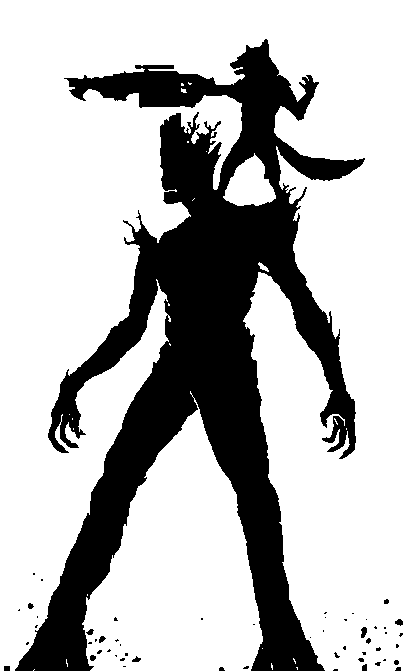

### Data Source:
Data source: The 1M Movie Lens datasets will be used for the project.

Datasets can be found at https://grouplens.org/datasets/movielens/1m/

Data dictionary: http://files.grouplens.org/datasets/movielens/ml-1m-README.txt


### Potential challenges and obstacles:
As there are no metrics to measure whether the recommender engine is good or not thus some form of human interpretation of the results will be required to gauge the performance of models.

### Measuring of results.
Whenever possible, baseline score will be set and metrics such as MSE, RSME, etc will be used to measure the effectiveness of the model.

Bearing any unforeseen circumstances for eg, interruptions cause by COVID19, this project should be achievable as data is available. Data cleaning is expected but minimal.

### First order of the day, load required libraries...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns
import warnings
import scipy
import sklearn

from scipy import sparse
from scipy.sparse.linalg import svds
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import preprocessing
sns.set()
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Install python libraries potentially not installed in user's PC

In [2]:
import pip

def install(package):
    pip.main(['install', package])

# Example
if __name__ == '__main__':
    try:
        import flask
    except ImportError:
        install('flask')
        import flask
    try:
        from flask_wtf import FlaskForm
    except ImportError:
        install('flask_wtf==0.14.3')
        from flask_wtf import FlaskForm
    try:
        from wtforms import StringField, SubmitField
    except ImportError:
        install('wtforms')
        from wtforms import StringField, SubmitField

## Load datasets
---

We'll be using the [MovieLens](https://grouplens.org/datasets/movielens/) dataset for building our recommendation engine. There are 3 datasets namely movies, ratings and users which will be used to build the recommender system. 

In [3]:
# Load datasets
ratings_list = [i.strip().split("::") for i in open('.\datasets\\ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('.\datasets\\users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('.\datasets\\movies.dat', 'r').readlines()]

ratings = pd.DataFrame(ratings_list, columns = ['userid', 'movieid', 'rating', 'timestamp'])
ratings = ratings.apply(pd.to_numeric)
movies = pd.DataFrame(movies_list, columns = ['movieid', 'title', 'genres'])
movies['movieid'] = movies['movieid'].apply(pd.to_numeric)
users = pd.DataFrame(users_list, columns = ['userid', 'gender', 'age', 'occupation', 'zipcode'])
users['userid'] = users['userid'].apply(pd.to_numeric)
users['age'] = users['age'].apply(pd.to_numeric)
users['occupation'] = users['occupation'].apply(pd.to_numeric)

In [4]:
n_users = ratings.userid.unique().shape[0]
n_movies = ratings.movieid.unique().shape[0]
print(f'Number of users: {str(n_users)} | Number of movies: {str(n_movies)}')
print('')
print(ratings.head(2))
print('')
print(movies.head(2))

Number of users: 6040 | Number of movies: 3706

   userid  movieid  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109

   movieid             title                        genres
0        1  Toy Story (1995)   Animation|Children's|Comedy
1        2    Jumanji (1995)  Adventure|Children's|Fantasy


In [5]:
# Per data dictionary, there are additional information on the numeric codes 
# used in the users dataset. 

#Create dictionary for age group.
data = {'age': [1, 18, 25, 35, 45, 50, 56], 
        'agegrp': ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']} 

# Create DataFrame for age group
age_grp = pd.DataFrame(data)

# Create dictionary for occupation
data = {'code': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
        'occupation': ['other', 'academic/educator', 'artist', 'cleric/admin',
                       'college/grad student', 'customer service',
                       'doctor/health care', 'executive/managerial', 'farmer',
                       'homemaker', 'K-12 student', 'lawyer', 'programmer',
                      'retired', 'sales/marketing', 'scientist',
                      'self-employed', 'technician/engineer',
                      'tradesman/craftsman', 'unemployed', 'writer']} 

# Create DataFrame for age group
occupation = pd.DataFrame(data)

### Let's explore the movie dataset a bit more.

In [6]:
# Extract movie titles excluding the year and concatenate the results into one long string
titles = movies['title'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
titles = ' '.join(titles)

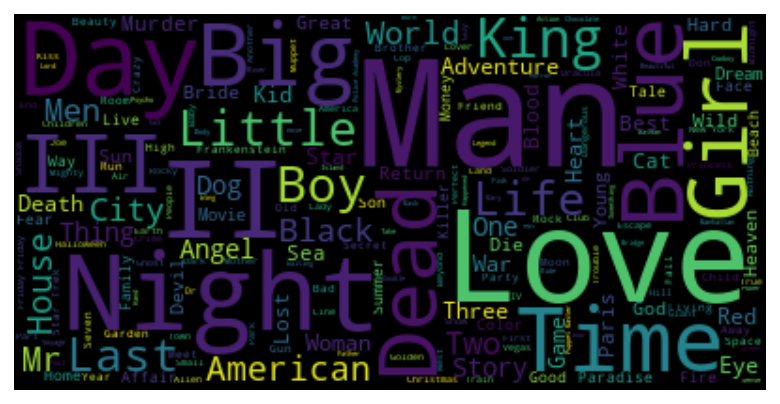

In [7]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(titles)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Hum... say all you want, Man and Love still triumph! Something about time too - Day, Night and Time, that is.

In [8]:
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# Extract movie titles excluding the year and concatenate the results into one long string
genres = movies['genres'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
genres = ' '.join(genres)

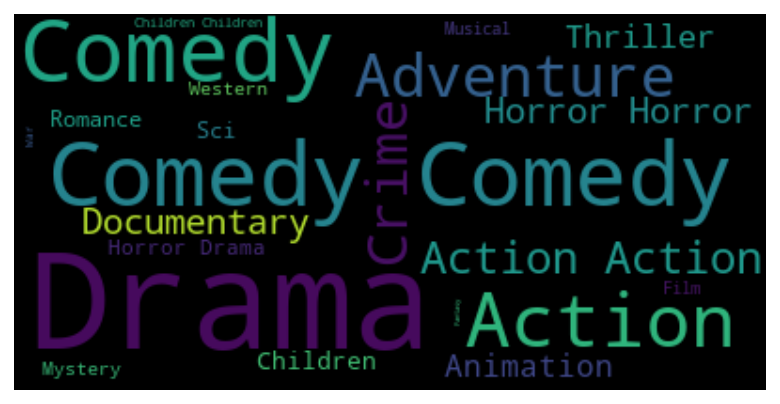

In [10]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(genres)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Interestingly, majority of the users like Drama and Comedy.

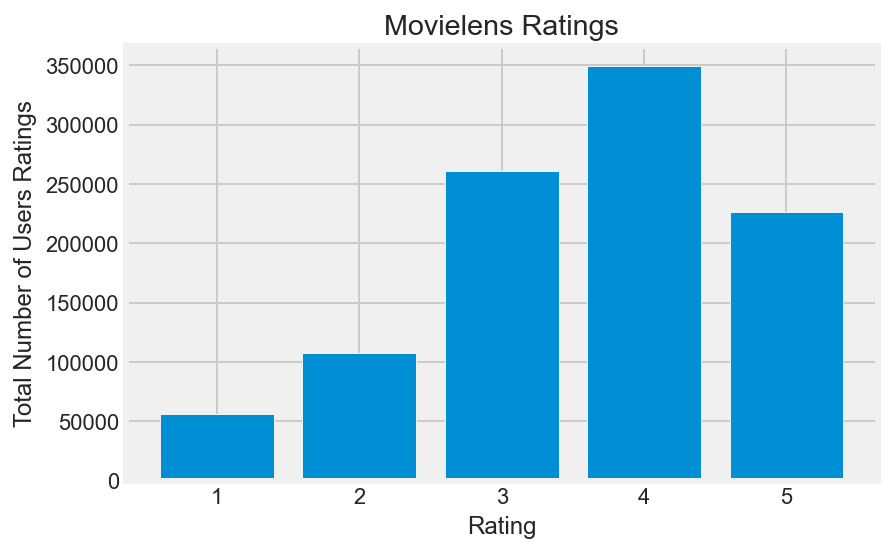

In [11]:
x = []
y = []
rating = ratings['rating'].value_counts()
for i, v in rating.iteritems():
    x.append(i)
    y.append(v)

#tick_label does the some work as plt.xticks()
plt.bar(x, y,tick_label = x)
plt.xlabel('Rating')
plt.ylabel('Total Number of Users Ratings')
plt.title('Movielens Ratings')
plt.show()

### Generally and as expected, users are not ready to give a rating of 5 even when the movie is fantastic. A rating of 4 is consider very good and there are rooms for improvements.

## Let's take a look at a simple item-based collaborative filtering model using Cosine Similarity to see a recommender system in action.

## Merge `movies` and `ratings`
---

Use `pd.merge` to **inner join** `movies` with `ratings` on the `movieId` column.

In [12]:
movie_ratings = pd.merge(ratings, movies, on = 'movieid')

## Create a pivot table
---

Because we're creating an item-based collaborative recommender (where item in this case is our movies), we'll set up our pivot table as follows:
1. The `title` will be the index
2. The `userId` will be the column
3. The `rating` will be the value

**If we were building a user-based collaborative recommender, we should transpose the pivot table ie. userid as the index and title as the column**

In [13]:
pivot = pd.pivot_table(movie_ratings, index = 'title', columns='userid', values = 'rating')
pivot.head()

userid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create sparse matrix
Calculate the cosine similarity for each movie using the `pairwise_distances` function. Before that, we need to create a sparse matrix (datatype) using `scipy`'s `sparse` module.

In [14]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))

In [15]:
type(sparse_pivot)

scipy.sparse.csr.csr_matrix

## Calculate cosine similarity
Use `sklearn's` built-in `pairwise_distances` function for the recommender resulting in a square matrix comparing every movie with every other movie in the dataset.

In [16]:
# Create a distance metrics similar to    
recommender = pairwise_distances(sparse_pivot, metric = 'cosine')

## Create distances DataFrame
---

At this point, we essentially have a recommender. We'll load it into a `pandas` DataFrame for readability. 

You'll notice that each movie has a "distance" of 0 with itself (along the diagonal).

In [17]:
recommender_df = pd.DataFrame(recommender, columns = pivot.index, index = pivot.index)
recommender_df.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.000000,0.927643,0.962989,0.920709,0.939162,1.00000,0.941381,0.810035,0.827746,0.905215,...,0.961275,0.923526,1.000000,0.955926,1.0,0.954720,0.960605,1.000000,0.879758,0.972997
'Night Mother (1986),0.927643,0.000000,0.884710,0.884455,0.840474,1.00000,0.923202,0.852563,0.904078,0.888587,...,0.946990,0.912172,0.936242,0.864038,1.0,0.908850,0.925213,1.000000,1.000000,0.922193
'Til There Was You (1997),0.962989,0.884710,0.000000,0.901244,0.933699,0.91975,0.872105,0.887346,0.874330,0.920885,...,0.970800,0.937107,1.000000,0.920813,1.0,0.977406,0.920739,1.000000,0.952474,0.936716
"'burbs, The (1989)",0.920709,0.884455,0.901244,0.000000,0.856380,1.00000,0.807809,0.753073,0.824115,0.829281,...,0.886614,0.792103,0.980038,0.861936,1.0,0.944296,0.838826,1.000000,0.966433,0.889475
...And Justice for All (1979),0.939162,0.840474,0.933699,0.856380,0.000000,1.00000,0.924907,0.805846,0.883621,0.794514,...,0.910002,0.846994,0.932991,0.890971,1.0,0.913920,0.889133,0.925683,1.000000,0.888960


## See how the recommender is performing
---

Although we do not have a metric to measure the performance but we can check out a few movies to see if the recommender aligns with our intuition. In the cell below we'll do the following:
1. Create a search term
2. Use that to find all titles matching the search query
3. For each title, we'll list off the following:
  1. The average rating
  2. The number of ratings
  3. The ten most similar movies

In [18]:
# Camel case the search string with .title() as movie titles are camel cased.
# We will use the word 'ring' as the search string so that we can use the same
# for other algorithms.
# search = input("What is your favorite movie: ").title()
search = 'Rings'

In [19]:
for title in movies.loc[movies['title'].str.contains(search), 'title']:
    print(title)
    print(f'Average rating: {round(pivot.loc[title, :].mean(),1)}') # Average ratings from users
    print(f'Number of rating: {pivot.loc[title, :].count()}')
    print('')
    print('Here are some movies you may like:')
    print('')
    print(recommender_df[title].sort_values()[1:11])
    print('')
    print('*' * 70)

Lord of the Rings, The (1978)
Average rating: 3.3
Number of rating: 438

Here are some movies you may like:

title
Tron (1982)                                   0.527622
Dune (1984)                                   0.554553
Dark Crystal, The (1982)                      0.556611
Superman (1978)                               0.577258
Heavy Metal (1981)                            0.579569
Time Bandits (1981)                           0.587320
Star Trek: The Wrath of Khan (1982)           0.589825
Star Trek: The Motion Picture (1979)          0.592009
Star Trek III: The Search for Spock (1984)    0.595640
Star Trek IV: The Voyage Home (1986)          0.599478
Name: Lord of the Rings, The (1978), dtype: float64

**********************************************************************
Postman Always Rings Twice, The (1981)
Average rating: 3.5
Number of rating: 155

Here are some movies you may like:

title
Body Heat (1981)                           0.623075
Marathon Man (1976)                

## Let's try Term Frequency (TF) and Inverse Document Frequency (IDF) to see if there is any difference to the model

In [20]:
# Ignoring stopwords (words with no semantics) in our corpus
stopwords_list = stopwords.words('english')

# Trains a model whose vectors size is 5000, composed by the main
# unigrams and bigrams found in the corpus, ignoring stopwords
tf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=10000,
                     stop_words=stopwords_list)

# tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix = tf.fit_transform(movies['title'])
tfidf_feature_names = tf.get_feature_names()
tfidf_matrix

<3883x116 sparse matrix of type '<class 'numpy.float64'>'
	with 4998 stored elements in Compressed Sparse Row format>

In [21]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [22]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

In [23]:
titles

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
                       ...                
3878               Meet the Parents (2000)
3879            Requiem for a Dream (2000)
3880                      Tigerland (2000)
3881               Two Family House (2000)
3882                 Contender, The (2000)
Name: title, Length: 3883, dtype: object

In [24]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [25]:
# let's get the top recommendations for a few movies and see how good the recommandations are.
genre_recommendations('Lord of the Rings, The (1978)').head(10)

1243                Deer Hunter, The (1978)
1359                          Grease (1978)
1367                          Jaws 2 (1978)
1913                       Halloween (1978)
1969       Cat from Outer Space, The (1978)
1986          Hot Lead and Cold Feet (1978)
2047          Lord of the Rings, The (1978)
2062    Autumn Sonata (Höstsonaten ) (1978)
2069                  Watership Down (1978)
2465                       Avalanche (1978)
Name: title, dtype: object

As we do not have a quantitative metric to measure the performance of the above 2 models so this will have to be done qualitatively. Although both methods are using Cosine Similarity but right off the bat, the simpler pivot table method is better as it allows wild-card search string ie, need not specify the entire movie title just a single word 'Rings' will do the job.
<br><br>
Furthermore, based on the search results, looks like adding TF/ IDF into the simple Cosine Similarity model worsen the performance. For eg, Grease and The Deer Hunt are not in any where related to Lord of the Rings.

# Evaluation
Evaluation is important for machine learning projects, because it allows to compare objectively different algorithms and hyperparameter choices for models. Let's try out some models that the performance can be measured.
<br><br>
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using **Cross-validation** techniques. We are using here a simple cross-validation approach named **holdout**, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the **test set**.
<br><br>
A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this project.

In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.  
This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
        **Note:** Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics

The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.  
Ps. Other popular ranking metrics are **NDCG@N** and **MAP@N**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). You can find a reference to implement this metrics in this [post](http://fastml.com/evaluating-recommender-systems/).

In [27]:
# Split the ratings data into train and test sets
train, test = train_test_split(ratings,
                                   stratify=ratings['userid'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(train))
print('# interactions on Test set: %d' % len(test))

# interactions on Train set: 800167
# interactions on Test set: 200042


In [28]:
# Indexing by user id to speed up the searches during evaluation
full_indexed = ratings.set_index('userid')
train_indexed = train.set_index('userid')
test_indexed = test.set_index('userid')
full_indexed.head()

,movieid,rating,timestamp
userid,,,
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291


In [29]:
# Funtion to get the interactions between the user and the movies
def get_items_interacted(user_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[user_id]['movieid']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [30]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

# Write a class for evaluating top 100 movies user has not interacted with before
class ModelEvaluator:
    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        interacted_items = get_items_interacted(user_id, full_indexed)
        all_items = set(movies['movieid'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, user_id):
        #Getting the items in test set
        interacted_values_testset = test_indexed.loc[user_id]
        if type(interacted_values_testset['movieid']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['movieid'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['movieid'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(user_id, 
                                               items_to_ignore=get_items_interacted(user_id, 
                                                                                    train_indexed), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['movieid'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['movieid'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, user_id in enumerate(list(test_indexed.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, user_id)  
            person_metrics['_user_id'] = user_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df

# Instantiate ModelEvaluator
model_evaluator = ModelEvaluator()

## Popularity Model
A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular movies that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.

In [31]:
# Recall that 'ratings' is the ratings
# 'movieid' is the movieid and 'rating' is rating.
item_popularity_df = ratings.groupby('movieid')['rating'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,movieid,rating
0,2858,14800
1,260,13321
2,1196,12836
3,1210,11598
4,2028,11507
5,1198,11257
6,593,11219
7,2571,11178
8,2762,10835
9,589,10751


In [32]:
# Write a class to recommends to a user the most popular movies 
# that the user has not previously consumed
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['movieid'].isin(items_to_ignore)] \
                               .sort_values('rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieid', 
                                                          right_on = 'movieid')[['rating', 'movieid', 'title', 'url', 'lang']]

        return recommendations_df

popularity_model = PopularityRecommender(item_popularity_df, movies)

Here we perform the evaluation of the Popularity model, according to the method described above.  
It achieved the **Recall@5** of **0.385**, which means that about **39%** of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And **Recall@10** was even higher (**55%**), as expected. It is a surprise that Popularity models could perform so well!

In [33]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
6039 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.3849241659251557, 'recall@10': 0.5478699473110646}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_user_id
253,130,197,463,0.280778,0.425486,4169
445,87,150,370,0.235135,0.405405,1680
7,127,178,349,0.363897,0.510029,4277
205,89,139,319,0.278997,0.435737,1941
1762,82,118,304,0.269737,0.388158,889
34,143,196,304,0.470395,0.644737,1181
167,84,132,269,0.312268,0.490706,3618
1513,91,126,265,0.343396,0.475472,2063
1160,72,101,261,0.275862,0.386973,1150
1001,94,135,257,0.365759,0.525292,1015


## Content-Based Filtering model

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the *cold-start* problem.
For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  
Here we are using a very popular technique in information retrieval (search engines) named [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model), it is to compute similarity between articles.  
See this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) (from slide 30) for more information on TF-IDF and Cosine similarity.

In [34]:
print(movies.head(3))
movies['title'] = movies['title'].map(lambda x: x[:-7])

   movieid                    title                        genres
0        1         Toy Story (1995)   Animation|Children's|Comedy
1        2           Jumanji (1995)  Adventure|Children's|Fantasy
2        3  Grumpier Old Men (1995)                Comedy|Romance


In [35]:
# Ignoring stopwords (words with no semantics) from English
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = movies['movieid'].tolist()
tfidf_matrix = vectorizer.fit_transform(movies['title'] + "" + movies['genres'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3883x107 sparse matrix of type '<class 'numpy.float64'>'
	with 5741 stored elements in Compressed Sparse Row format>

In [36]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['movieid'])
    
    user_item_strengths = np.array(interactions_person_df['rating']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), 
                                              axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = ratings[ratings['movieid'] \
                                                   .isin(movies['movieid'])].set_index('userid')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [37]:
user_profiles = build_users_profiles()
len(user_profiles)

6040

Let's take a look in the profile. It is a [unit vector](https://en.wikipedia.org/wiki/Unit_vector) of 5000 length. The value in each position represents how relevant is a token (unigram or bigram) for me.  
Looking my profile, it appears that the top relevant tokens really represent my professional interests in **machine learning**, **deep learning**, **artificial intelligence** and **google cloud platform**! So we might expect good recommendations here!

In [38]:
# Let's take a look at user id 453's genre preference 
df = pd.merge(ratings, movies, how='left', on = 'movieid')
df[['title', 'genres']].loc[df['userid'] == 453]

,title,genres
67265,Who Framed Roger Rabbit?,Adventure|Animation|Film-Noir
67266,Andre,Adventure|Children's
67267,"Bridge on the River Kwai, The",Drama|War
67268,X-Men,Action|Sci-Fi
67269,"Honey, I Shrunk the Kids",Adventure|Children's|Comedy|Fantasy|Sci-Fi
...,...,...
67654,Rosencrantz and Guildenstern Are Dead,Comedy|Drama
67655,Flight of the Navigator,Adventure|Children's|Sci-Fi
67656,Manhattan,Comedy|Drama|Romance
67657,Dead Poets Society,Drama


In [39]:
# Although this is very subjective but the tfidf filtered results is almost
# similar to the user's preference ie, drama, comedy and adventure.
profile = user_profiles[453]
print(profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[453].flatten().tolist()), key=lambda x: -x[1])[:10],
             columns=['token', 'relevance'])

(1, 107)


,token,relevance
0,drama,0.440238
1,comedy,0.303936
2,adventure,0.290016
3,fi,0.285483
4,thriller,0.280237
5,sci,0.273654
6,sci fi,0.273654
7,war,0.261973
8,romance,0.234500
9,thecomedy,0.169603


In [40]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['movieid', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieid', 
                                                          right_on = 'movieid')[['recStrength', 'movieid', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(movies)

#### Somehow, the result is worse than the popularity model.

In [41]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
6039 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16951940092580559, 'recall@10': 0.27765169314443966}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_user_id
253,27,55,463,0.058315,0.118790,4169
445,48,71,370,0.129730,0.191892,1680
7,46,78,349,0.131805,0.223496,4277
205,41,68,319,0.128527,0.213166,1941
1762,67,94,304,0.220395,0.309211,889
34,24,36,304,0.078947,0.118421,1181
167,31,51,269,0.115242,0.189591,3618
1513,19,46,265,0.071698,0.173585,2063
1160,15,35,261,0.057471,0.134100,1150
1001,22,35,257,0.085603,0.136187,1015


# Collaborative Filtering Model
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.<br>

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.<br>

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use.
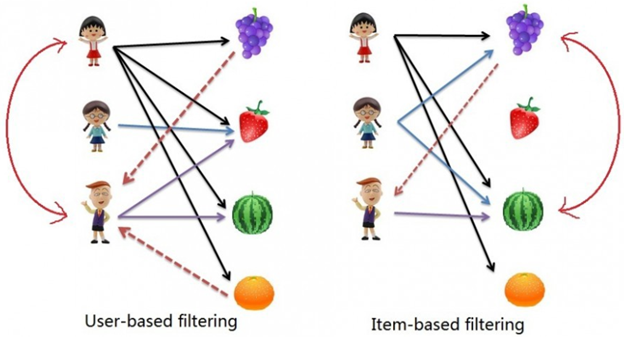

<details><summary>User-User Collaborative Filtering</summary>
Here we look to recommend movies to a user based on other users with similar movie preferences. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelized-able system.
</details>
<br>
<details><summary>Item-Item Collaborative Filtering</summary>
It is quite similar to previous algorithm, but instead of finding user’s look-alike, we try finding movie’s look-alike. Once we have movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.
</details>
<br>
In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:
<br>
<details><summary>Jaccard Similarity</summary>
Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B. It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked.
</details>
<br>
<details><summary>Cosine Similarity</summary>
(as in the Content-Based system) Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B. Closer the vectors, smaller will be the angle and larger the cosine.
</details>
<br>
<details><summary>Pearson Similarity</summary>
Similarity is the Pearson coefficient between the two vectors. For the purpose of diversity, I will use Pearson Similarity in this implementation.
</details>

Collaborative Filtering (CF) has two main implementation strategies:  
- **Memory-based**: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).  
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. A nice Python implementation of this approach in available in [Crab](http://muricoca.github.io/crab/).
- **Model-based**: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

## Matrix Factorization
Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

Here we a use popular latent factor model named [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). There are other matrix factorization frameworks more specific to CF like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec) or [python-recsys](https://github.com/ocelma/python-recsys). We chose a [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) implemenation of SVD because it is available on Kaggle kernels.  
Ps. See an example of SVD on a movies dataset in this [blog post](https://beckernick.github.io/matrix-factorization-recommender/).

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

### Singular Value Decompostion (SVD)
Singular value decomposition (SVD) is a matrix factorization method. SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:
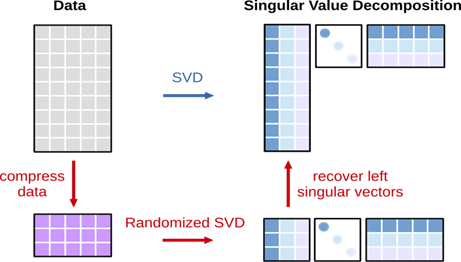

In [42]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = train.pivot(index='userid', columns='movieid', values='rating').fillna(0)
users_items_pivot_matrix_df.head(10)

movieid,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userid,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [43]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [5., 5., 0., ..., 0., 0., 0.]])

In [44]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [45]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [46]:
print(f'U.shape: {U.shape}')
print(f'Vt.shape: {Vt.shape}')
sigma = np.diag(sigma)
print(f'sigma.shape: {sigma.shape}')

U.shape: (6040, 15)
Vt.shape: (15, 3679)
sigma.shape: (15, 15)


In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.84988727e+00,  4.30051191e-01,  3.50835383e-02, ...,
         6.01170469e-03,  1.31304139e-02,  1.13889270e-01],
       [ 1.13091480e+00,  3.95059520e-01,  2.20488116e-01, ...,
         1.60404075e-02,  2.90307107e-03,  3.59626076e-01],
       [ 1.49207770e+00,  5.98091950e-02,  9.66950701e-02, ...,
        -1.57054437e-02, -1.53364381e-02,  4.06513132e-03],
       ...,
       [ 4.11632567e-01,  1.21478084e-02,  1.37673981e-03, ...,
        -1.05377419e-02, -3.01837867e-03, -3.97361712e-02],
       [ 1.27402135e+00,  3.72125400e-01,  1.79575007e-01, ...,
        -6.79395710e-03,  5.84021604e-04, -1.82666726e-01],
       [ 8.01656889e-01, -1.84360369e-01, -4.26097129e-01, ...,
         1.29391983e-01,  5.68780355e-02,  5.10056832e-01]])

In [48]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieid,,,,,,,,,,,,,,,,,,,,,
1,1.849887,1.130915,1.492078,-0.106240,1.459523,0.966223,0.910511,0.984001,2.656181,5.376050,...,0.589278,1.662728,0.194371,-0.227311,1.558797,2.746749,1.048532,0.411633,1.274021,0.801657
2,0.430051,0.395060,0.059809,-0.167707,0.035422,0.336004,0.087572,0.138889,0.312924,2.099895,...,0.199730,0.230239,0.033620,0.010027,0.755760,1.140093,0.085487,0.012148,0.372125,-0.184360
3,0.035084,0.220488,0.096695,0.039512,-0.202360,0.206283,0.083225,0.128995,0.076611,1.174089,...,0.040941,0.025269,0.074806,-0.032880,0.369946,-0.085863,-0.065340,0.001377,0.179575,-0.426097
4,-0.005224,0.059027,-0.066696,0.036240,0.071532,0.137148,-0.049250,0.260394,0.040115,0.383194,...,0.025844,-0.103519,-0.016473,-0.024541,0.339730,0.313456,-0.124092,-0.008664,0.028697,-0.038467
5,0.021444,0.133313,0.024126,-0.023111,-0.149205,0.162034,-0.015817,0.078789,0.039923,0.907782,...,0.031448,-0.036237,-0.014421,-0.013329,0.329613,-0.121905,-0.114788,-0.003582,0.138261,-0.321637
6,-0.283726,0.858509,0.158488,0.219998,1.268669,-0.164445,0.777980,1.089350,0.809094,-1.248794,...,0.145397,-0.201680,0.646589,0.234151,0.053514,1.152040,0.276068,-0.057458,-0.367799,0.641143
7,0.004044,0.373524,-0.000683,0.064481,-0.053869,0.505160,0.044285,0.399656,-0.002587,1.449121,...,0.123322,-0.041752,0.094116,0.022525,0.774914,0.594508,-0.056130,0.040284,0.491854,-0.109325
8,0.109325,0.021445,-0.002493,-0.035213,-0.004994,0.064822,-0.009901,0.005262,0.046663,0.251069,...,0.015257,0.031230,-0.024769,-0.007999,0.018095,0.071325,-0.043169,-0.004895,0.048433,-0.050938
9,-0.046152,0.102988,-0.010247,-0.020722,-0.018153,-0.012549,0.072123,0.019380,0.003068,0.054893,...,-0.001537,-0.051761,0.050349,0.006094,0.016433,-0.039174,-0.070459,-0.022011,-0.048028,-0.151068


In [49]:
len(cf_preds_df.columns)

6040

In [50]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['movieid'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieid', 
                                                          right_on = 'movieid')[['recStrength', 'movieid', 'title', 'genres']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, movies)

Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5 (59%)** and a whopping **Recall@10 (74%)** values higher than Popularity model (refer to the screen-shot below).  

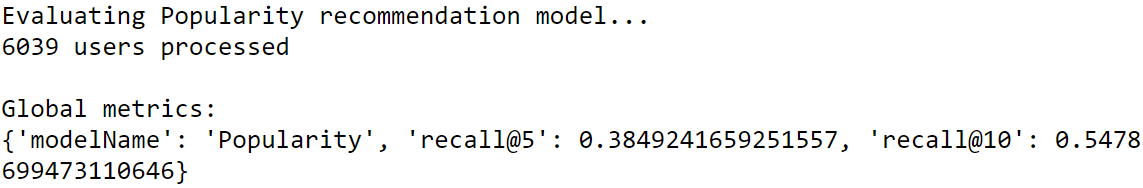

In [51]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
6039 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.5907059517501325, 'recall@10': 0.7395446956139211}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_user_id
253,212,263,463,0.457883,0.568035,4169
445,126,185,370,0.340541,0.500000,1680
7,175,216,349,0.501433,0.618911,4277
205,155,206,319,0.485893,0.645768,1941
1762,107,142,304,0.351974,0.467105,889
34,160,217,304,0.526316,0.713816,1181
167,134,177,269,0.498141,0.657993,3618
1513,151,196,265,0.569811,0.739623,2063
1160,94,136,261,0.360153,0.521073,1150
1001,135,185,257,0.525292,0.719844,1015


## Hybrid Recommender

What if we combine Collaborative Filtering and Content-Based Filtering approaches?
Would that provide us with more accurate recommendations?
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.
Let's build a simple hybridization method, by only multiply the CF score with the Content-Based score, and ranking by resulting score.

In [52]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by movieid
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'movieid', 
                                   right_on = 'movieid')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'movieid', 
                                                          right_on = 'movieid')[['recStrengthHybrid', 'movieid', 'title','genres']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, movies)

**It appears we have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a **Recall@5** of **41%** and **Recall@10** of **46%**

In [53]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
6039 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4082392697533518, 'recall@10': 0.46061827016326573}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_user_id
253,108,124,463,0.233261,0.267819,4169
445,78,99,370,0.210811,0.267568,1680
7,103,113,349,0.295129,0.323782,4277
205,87,98,319,0.272727,0.307210,1941
1762,82,94,304,0.269737,0.309211,889
34,82,88,304,0.269737,0.289474,1181
167,85,93,269,0.315985,0.345725,3618
1513,67,74,265,0.252830,0.279245,2063
1160,62,76,261,0.237548,0.291188,1150
1001,68,76,257,0.264591,0.295720,1015


## Comparing the methods

In [54]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.384924,0.547870
Collaborative Filtering,0.590706,0.739545
Content-Based,0.169519,0.277652
Hybrid,0.408239,0.460618


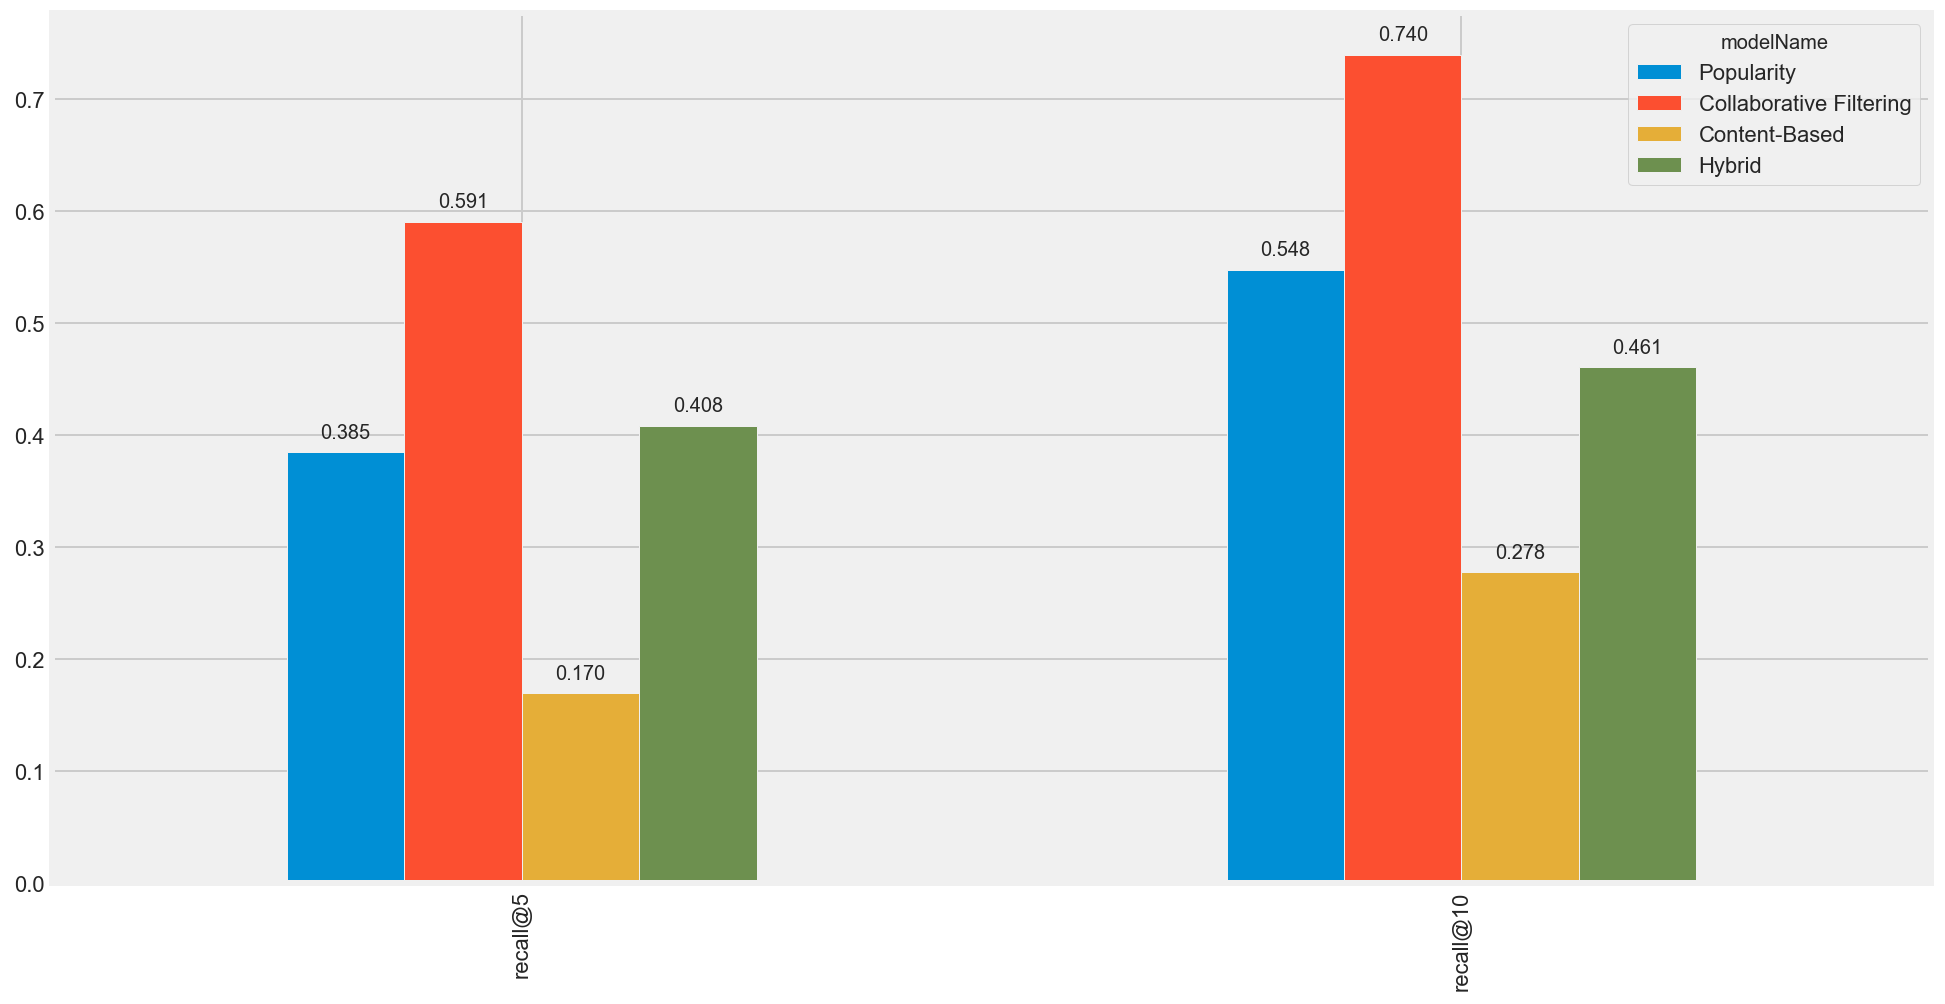

In [55]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., 
                                          p.get_height()), ha='center', 
                va='center', xytext=(0, 10), textcoords='offset points')

## Testing
Let's test the best model (Collaborative Filtering) for the user.

In [56]:
def inspect_interactions(user_id, test_set=True):
    if test_set:
        interactions_df = test_indexed
    else:
        interactions_df = train_indexed
    return interactions_df.loc[user_id].merge(movies, how = 'left', 
                                                      left_on = 'movieid', 
                                                      right_on = 'movieid') \
                          .sort_values('rating', ascending = False)[['rating', 
                                                                          'movieid',
                                                                          'title', 'genres']]

**The recommendations matches user id 453's based on ratings.**

In [57]:
inspect_interactions(453, test_set=False).head(10)

,rating,movieid,title,genres
64,5,1210,Star Wars: Episode VI - Return of the Jedi,Action|Adventure|Romance|Sci-Fi|War
49,5,1967,Labyrinth,Adventure|Children's|Fantasy
287,5,1198,Raiders of the Lost Ark,Action|Adventure
173,5,924,2001: A Space Odyssey,Drama|Mystery|Sci-Fi|Thriller
178,5,2947,Goldfinger,Action
83,5,1244,Manhattan,Comedy|Drama|Romance
183,5,3897,Almost Famous,Comedy|Drama
186,5,1387,Jaws,Action|Horror
188,5,745,"Close Shave, A",Animation|Comedy|Thriller
189,5,1019,"20,000 Leagues Under the Sea",Adventure|Children's|Fantasy|Sci-Fi


**The recommendations really matches user id 453's genre preference.**

In [58]:
cf_recommender_model.recommend_items(453, topn=10, verbose=True)

,recStrength,movieid,title,genres
0,5.395026,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Fantasy|Sci-Fi
1,5.336381,1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Drama|Sci-Fi|War
2,5.100777,858,"Godfather, The",Action|Crime|Drama
3,4.370018,1136,Monty Python and the Holy Grail,Comedy
4,4.252807,296,Pulp Fiction,Crime|Drama
5,4.116705,1198,Raiders of the Lost Ark,Action|Adventure
6,4.010251,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
7,3.997053,2028,Saving Private Ryan,Action|Drama|War
8,3.963800,318,"Shawshank Redemption, The",Drama
9,3.896723,1221,"Godfather: Part II, The",Action|Crime|Drama


# Conclusion
We started off with a simple content-based recommender system using Cosine Similarity. We then use TF/ IDF it turned out that the simple Cosine Similarity model is better.
<br><br>
We then move on to using main Recommender Systems techniques for movie recommendation using content-based filtering, collaborative filtering and a hybrid method. Collaborative Filtering is the champion.

There is large room for improvements of the results. Here are some tips:
- In this example, we've completely ignored the time, considering that all articles were available to be recommended to users at any time. A better approach would be to filter only articles that were available for users at a given time.
- You could leverage the available contextual information to model users preferences across time (period of day, day of week, month), location (country and state/district) and devices (browser, mobile native app).  
This contextual information can be easily incorporated in [Learn-to-Rank](https://en.wikipedia.org/wiki/Learning_to_rank) models (like XGBoost Gradient Boosting Decision Trees with ranking objective) or Logistic models (with categorical features [One-Hot encoded](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) or [Feature Hashed](https://en.wikipedia.org/wiki/Feature_hashing)). Take a look in the summary my solution shared for [Outbrain Click Prediction](https://www.kaggle.com/c/outbrain-click-prediction/discussion/27897#157215) competition. 
- Those basic techniques were used for didactic purposes. There are more advanced techniques in RecSys research community, specially advanced Matrix Factorization and Deep Learning models.  

To find out more about state-of-the-art methods published in Recommender Systems on [ACM RecSys conference](https://recsys.acm.org/).  
Some other Collaborative Filtering frameworks in this dataset, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec),  [python-recsys](https://github.com/ocelma/python-recsys) and [Spark ALS Matrix Factorization](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) (distributed implementation for large datasets).  
Take a look in this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) for a production recommender system, focused on Content-Based Filtering and Topic Modeling techniques.